## FaceNet Project 

In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive" ,force_remount=True)


Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(path)

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks

In [ ]:
# drive.flush_and_unmount()
# drive.mount("/content/Drive")
# !rm -rf Drive
!ls

 Dataset			       images_file3.pkl        X_test3.pkl
 emb-model3.h5			       model-best-file1.hdf5   X_test.pkl
 emb-model.h5			       model-best-file3.hdf5   X_train3.pkl
 Face				       Nghia.ipynb	       X_train.pkl
 Facenet			       nn4.small2.v1.t7        y_labels1.pkl
 FaceNet1.ipynb			       Predict.ipynb	       y_labels3.pkl
'facenet-face-recognition (1).ipynb'   Predict_Long.ipynb      y_test3.pkl
 FaceNet.ipynb			       Preprocess_data	       y_test.pkl
 FaceNet_v2.ipynb		       test		       y_train3.pkl
 faces1.pkl			       test2		       y_train.pkl
 faces3.pkl			       Train_test_data
 images_file1.pkl		       Untitled0.ipynb


### Extract face

In [ ]:
!pip install face_recognition

In [ ]:
from face_recognition import face_locations
import matplotlib.pyplot as plt
IMAGE_TEST = "./Dataset/sontung/027.jpg"
def _image_read(image_path):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

#trích xuất toạ độ face
def _extract_bbox(image, single = True):
  bboxs = face_locations(image)
  if len(bboxs)==0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

In [ ]:
def _extract_face(image, bbox, face_scale_thres = (20, 20), required_size=(160, 160)):
  h, w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  # extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]

  # ensure the face width and height are sufficiently large
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None
  else:
    img = cv2.resize(face,required_size)
    return img

# bbox = _extract_bbox(image)
# face = _extract_face(image, bbox)
# print(type(face))
# plt.imshow(face)

In [ ]:
# test face recognition
IMAGE_TEST = "./Dataset/sontung/031.jpg"
def extract(image_path):
    image = _image_read(image_path)
    bbox =_extract_bbox(image, single=True)
    face = _extract_face(image, bbox, face_scale_thres = (20, 20))
    return face
face = extract(IMAGE_TEST )
if face is not None:
  print(type(face))
  print(face.shape)
  plt.imshow(face)
else:
  print('None')

None


### Create for loop to extract all image in dataset

In [ ]:
!pip install imutils

In [ ]:
from imutils import paths
DATASET_PATH = "./Dataset"

def _model_processing():
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("/")
    #take labels
    name = split_img_links[-2]
    face = extract(image_link)
    if face is not None:
      faces.append(face)
      y_labels.append(name)
      images_file.append(image_link)
      total += 1
    else:
      next
#   print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

In [ ]:
# print(len(y_labels))
# plt.imshow(faces[0])
# print(np.array(images_file).shape)

In [ ]:
## save to pickle file
import pickle

def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle(faces, "./faces3.pkl")
_save_pickle(y_labels, "./y_labels3.pkl")
_save_pickle(images_file, "./images_file3.pkl")

In [ ]:
# y_labels = _load_pickle("./Preprocess_data/y_labels.pkl")
# faces = _load_pickle("./Preprocess_data/faces.pkl")
# files = _load_pickle("./Preprocess_data/images_file.pkl")
# # files = convert(files)
# # y_labels = tuple(y_labels)
# print(len(files))
# files = list(files[149])
# # print(files[119])
# # print((y_labels[119]))
# file_id_mapping_train = { files[i]: y_labels[i] for i in range (len(files)) }
# # for i in range(len(files)):
# #   print('yes')
# #   break
# # file_id_mapping_train


## Split train/test

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.layers import Input
y_labels = _load_pickle("./y_labels3.pkl")
faces = _load_pickle("./faces3.pkl")
files = _load_pickle("./images_file3.pkl")


ids = np.arange(len(y_labels))
# files

In [ ]:
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(files), y_labels, ids, test_size = 0.2, stratify = y_labels)

In [ ]:
len(X_train)

888

In [ ]:
file_id_mapping_train = { X_train[i]: y_train[i] for i in range (len(y_train)) }
file_id_mapping_test = { X_test[i]: y_test[i] for i in range (len(y_test))}
_save_pickle(X_train, "./X_train3.pkl")
_save_pickle(X_test, "./X_test3.pkl")
_save_pickle(y_train, "./y_train3.pkl")
_save_pickle(y_test, "./y_test3.pkl")
file_id_mapping_train

## Batch gen

In [ ]:
from collections import defaultdict
class sample_gen(object):
    def __init__(self, file_class_mapping, other_class = "new_whale"):
        self.file_class_mapping= file_class_mapping
        self.class_to_list_files = defaultdict(list)
        # self.list_other_class = []
        self.list_all_files = list(file_class_mapping.keys())
        self.range_all_files = list(range(len(self.list_all_files)))

        for file, class_ in file_class_mapping.items():
            # if class_ == other_class:
            #     self.list_other_class.append(file)
            # else:
          self.class_to_list_files[class_].append(file)

        self.list_classes = list(set(self.file_class_mapping.values()))
        self.range_list_classes= range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight/np.sum(self.class_weight)

    def get_sample(self):

        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]

        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
#         print(examples_class_idx)
#         print(examples_class_idx[0])
#         print(examples_class_idx[1])
        positive_example_1, positive_example_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]],\
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]


        negative_example = None
        while negative_example is None or self.file_class_mapping[negative_example] == \
                self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
        return positive_example_1, negative_example, positive_example_2

In [ ]:
pos1, neg, pos2 = sample_gen(file_id_mapping_train).get_sample()
print(pos1)
print(pos2)
print(neg)
pos1_test, neg_test, pos2_test = sample_gen(file_id_mapping_test).get_sample()
print(pos1_test)
print(pos2_test)
print(neg_test)

./Dataset/John_Allen_Muhammad/John_Allen_Muhammad_0007.jpg
./Dataset/John_Allen_Muhammad/John_Allen_Muhammad_0011.jpg
./Dataset/John_Kerry/John_Kerry_0012.jpg
./Dataset/Ari_Fleischer/Ari_Fleischer_0010.jpg
./Dataset/Ari_Fleischer/Ari_Fleischer_0003.jpg
./Dataset/Joe_Lieberman/Joe_Lieberman_0011.jpg


In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input
batch_size = 10
# def augment(im_array):
#     if np.random.uniform(0, 1) > 0.9:
#         im_array = np.fliplr(im_array)
#     return im_array
def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []
        i = 0
        while i < batch_size:
#             print(i)
            positive_example_1, negative_example, positive_example_2 = triplet_gen.get_sample()
           
            
            positive_example_1_img = extract(positive_example_1)
            if positive_example_1_img is None:
              continue
            negative_example_img = extract(negative_example)
            if negative_example_img is None:
              continue
            positive_example_2_img = extract(positive_example_2)
            if positive_example_2_img is None:
              continue
                        
            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)
            i += 1

        A = preprocess_input(np.array(list_positive_examples_1))
        B = preprocess_input(np.array(list_positive_examples_2))
        C = preprocess_input(np.array(list_negative_examples))
        
        label = None
        
        yield ({'anchor_input': A, 'positive_input': B, 'negative_input': C}, label)

## Triplet Loss

In [ ]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    loss = K.maximum(0.0, 1 + loss)
    return K.mean(loss)

## Base Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras import backend as K

image_size = 160
embedding_dim = 128

def GetModel():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='max')
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    embedding_model = Model(base_model.input, x, name="embedding")

    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embedding]
       
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))

    return embedding_model, triplet_model
embedding_model, triplet_model = GetModel()
triplet_model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 128)          23849984    anchor_input[0][0]               
                             

In [ ]:
def ShowImg(img):
    plt.figure(figsize=(15,8))
    plt.imshow(img.astype('uint8'))
    plt.show()
    plt.close()

In [ ]:
gen_tr = gen(sample_gen(file_id_mapping_train))
gen_te = gen(sample_gen(file_id_mapping_test))

# batch = next(gen_tr)

# print(len(batch[0]['anchor_input']))
# img = batch[0]['anchor_input'][2]
# mean = [103.939, 116.779, 123.68]
# img[..., 0] += mean[0]
# img[..., 1] += mean[1]
# img[..., 2] += mean[2]
# img = img[..., ::-1]
# print(img.shape)
# ShowImg(img)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
filepath="./model-best-file3.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor = 'loss', 
                             verbose = 1, 
                             save_best_only = True,
                             save_weights_only=False, 
                             mode = 'min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=2)
callbacks_list = [checkpoint, early]


In [ ]:
for i, layer in enumerate(embedding_model.layers):
    print(i, layer.name, layer.trainable)

In [ ]:
for layer in embedding_model.layers[178:]:
    layer.trainable = True
for layer in embedding_model.layers[:178]:
    layer.trainable = False

In [ ]:
triplet_model.compile(loss=None, optimizer=Adam(0.0001))

history = triplet_model.fit(gen_tr,  
                              epochs=10, 
                              callbacks = callbacks_list,
                              verbose=1, 
                              steps_per_epoch=50 
                            )

Epoch 1/10
50/50 [==============================] - 160s 2s/step - loss: 0.9672

Epoch 00001: loss improved from inf to 0.96311, saving model to ./model-best-file3.hdf5
Epoch 2/10
50/50 [==============================] - 120s 2s/step - loss: 0.9506

Epoch 00002: loss improved from 0.96311 to 0.95168, saving model to ./model-best-file3.hdf5
Epoch 3/10
50/50 [==============================] - 123s 2s/step - loss: 0.9384

Epoch 00003: loss improved from 0.95168 to 0.94296, saving model to ./model-best-file3.hdf5
Epoch 4/10
50/50 [==============================] - 125s 3s/step - loss: 0.9339

Epoch 00004: loss improved from 0.94296 to 0.93603, saving model to ./model-best-file3.hdf5
Epoch 5/10
50/50 [==============================] - 124s 3s/step - loss: 0.9242

Epoch 00005: loss improved from 0.93603 to 0.92090, saving model to ./model-best-file3.hdf5
Epoch 6/10
50/50 [==============================] - 130s 3s/step - loss: 0.9391

Epoch 00006: loss did not improve from 0.92090
Epoch 7/10


In [ ]:
# X_train = _load_pickle("../input/preprocess/images_file1.pkl")
# y_train = _load_pickle("../input/preprocess/y_labels1.pkl")
# file_id_mapping_train = { X_train[i]: y_train[i] for i in range (len(y_train)) }
# len(file_id_mapping_train)

In [ ]:
from keras.models import load_model


for layer in embedding_model.layers[150:]:
    layer.trainable = True
for layer in embedding_model.layers[:150]:
    layer.trainable = False


triplet_model.compile(loss=None, optimizer=Adam(0.0001))

history = triplet_model.fit_generator(gen_tr,  
                                    epochs=20,
                                    callbacks = callbacks_list,
                                    verbose=1, 
                                    workers=1,
                                    steps_per_epoch=70, 
                                    use_multiprocessing=True)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
70/70 [==============================] - 182s 3s/step - loss: 0.9275

Epoch 00001: loss improved from 0.92090 to 0.91075, saving model to ./model-best-file3.hdf5
Epoch 2/20
70/70 [==============================] - 167s 2s/step - loss: 0.8161

Epoch 00002: loss improved from 0.91075 to 0.76552, saving model to ./model-best-file3.hdf5
Epoch 3/20
70/70 [==============================] - 168s 2s/step - loss: 0.6686

Epoch 00003: loss improved from 0.76552 to 0.63286, saving model to ./model-best-file3.hdf5
Epoch 4/20
70/70 [==============================] - 182s 3s/step - loss: 0.6004

Epoch 00004: loss improved from 0.63286 to 0.55390, saving model to ./model-best-file3.hdf5
Epoch 5/20
70/70 [==============================] - 183s 3s/step - loss: 0.5628

Epoch 00005: loss improved from 0.55390 to 0.52185, saving model to ./model-best-file3.hdf5
Epoch 6/20
70/70 [==============================] - 176s 3s/step - loss: 0.4350

Epoch 00006: loss improved from 0.52185 to 0.43217, sa

In [ ]:
embedding_model.save('./emb-model3.h5')

In [ ]:
import seaborn as sns
def eva_plot(History, epoch):
    plt.figure(figsize=(20,10))
    plt.figure(figsize=(20,10))
    sns.lineplot(range(1, epoch+1), History.history['loss'], label='Train loss')
    plt.legend(['train', 'validaiton'], loc='upper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title("Loss Graph")
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 1440x720 with 0 Axes>

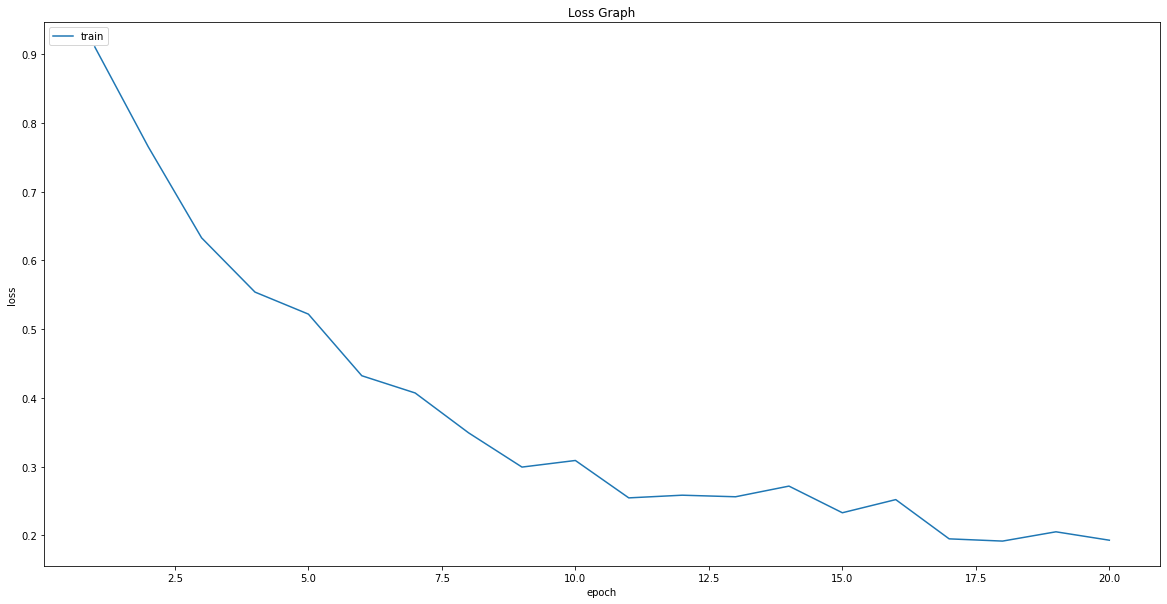

In [ ]:
eva_plot(history, 20)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

In [ ]:
for i, layer in enumerate(embedding_model.layers):
    print(i, layer.name, layer.trainable)

### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

y_preds = []
for vec in embed_vecs_test:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(embed_vecs,  vec, labels_train)
  y_preds.append(y_pred)
print(accuracy_score(y_preds, labels_test))

0.5605381165919282
